# Time Series Forecasting with Sarimax

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose       
from pmdarima import auto_arima                              

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('../Data/HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


###  Plotting the source data

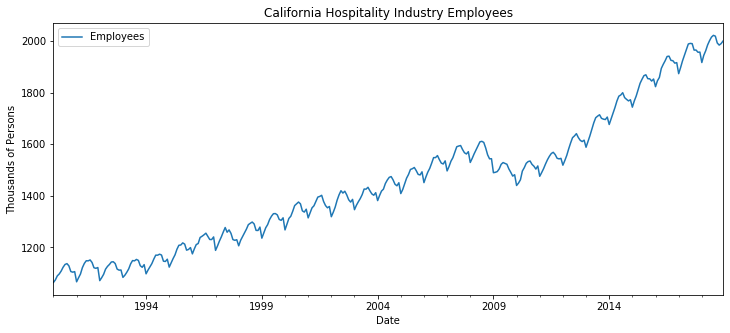

In [3]:
title='California Hospitality Industry Employees'
ax = df.plot(figsize=(12,5),title=title)
ax.set(ylabel='Thousands of Persons');

### Running an ETS Decomposition

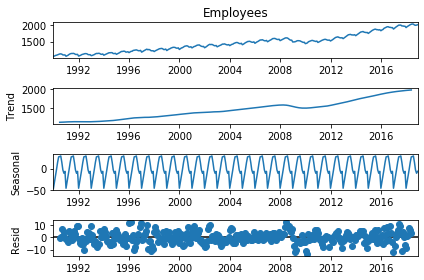

In [4]:
result = seasonal_decompose(df['Employees'], model='add')
result.plot();

### Running pmdarima.auto_arima to obtain recommended orders


In [5]:
auto_arima(df['Employees'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Sun, 27 Sep 2020   AIC                           2208.504
Time:                                      12:44:47   BIC                           2231.600
Sample:                                           0   HQIC                          2217.700
                                              - 348                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9244      0.045     20.526      0.000       0.836       1.013
ma.L1         -0.9440      0.070    -13.550      0.000      -1.081      -0.807
ma.L2          0.1288      0.060      2.156      0.031       0.012       0.246
ar.S.L12       0.9972      0.001    700.653      0.000       0.994       1.000
ma.S.L12      -0.7490      0.043    -17.347      0.000      -0.834      -0.664
sigma2        29.2966      1.717     17.062      0.000      25.931      32.662
===================================================================================
Ljung-Box (Q):                       31.49   Jarque-Bera (JB):                67.42
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###  Splitting the data into train/test sets


In [6]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

### Fitting a SARIMA(0,1,0)(2,0,0,12) model to the training set

In [8]:
model = SARIMAX(train['Employees'],order=(0,1,0),seasonal_order=(2,0,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Employees   No. Observations:                  336
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1095.407
Date:                            Sun, 27 Sep 2020   AIC                           2196.814
Time:                                    12:44:48   BIC                           2208.256
Sample:                                01-01-1990   HQIC                          2201.375
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5204      0.040     13.051      0.000       0.442       0.599
ar.S.L24       0.4385      0.041     10.593      0.000       0.357       0.520
sigma2        37.1907      2.165     17.175      0.000      32.947      41.435
===================================================================================
Ljung-Box (Q):                      102.80   Jarque-Bera (JB):                56.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.35
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###  Obtaining predicted values


In [9]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0)(2,0,0,12) Predictions')

###  Plotting predictions against known values


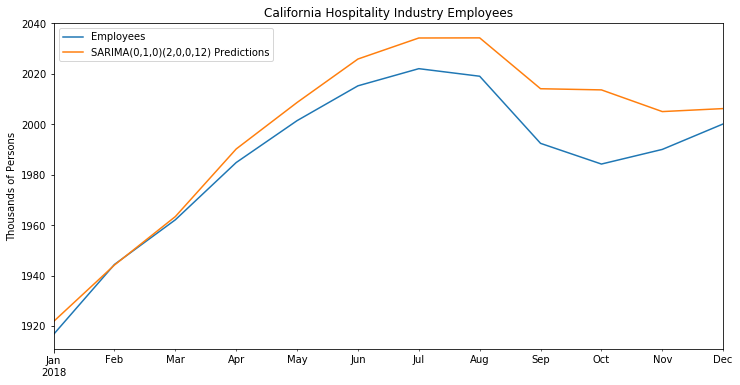

In [10]:
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = test['Employees'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

###  Evaluating the Model using MSE and RMSE


In [11]:
error1 = mean_squared_error(test['Employees'], predictions)
error2 = rmse(test['Employees'], predictions)
print(f'SARIMA(0,1,0)(2,0,0,12) MSE Error: {error1:11.10}')
print(f'SARIMA(0,1,0)(2,0,0,12) RMSE Error: {error2:11.10}')

SARIMA(0,1,0)(2,0,0,12) MSE Error: 182.8506658
SARIMA(0,1,0)(2,0,0,12) RMSE Error: 13.52222858


###  Retraining the model on the full data and forecasting one year into the future

In [12]:
model = SARIMAX(df['Employees'],order=(0,1,0),seasonal_order=(2,0,0,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,0)(2,0,0,12) Forecast')

###  Plotting the forecasted values alongside the original data


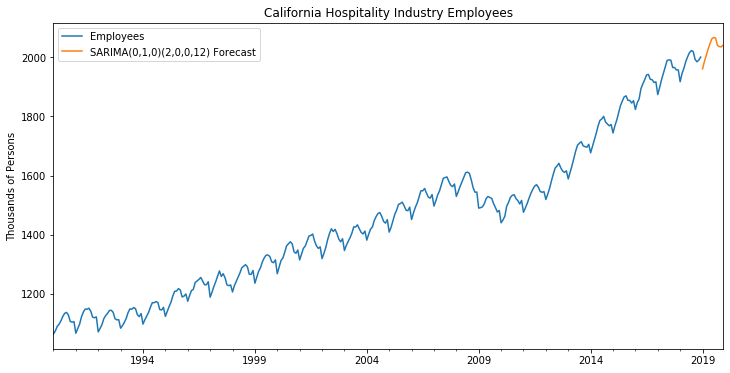

In [13]:
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = df['Employees'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

##  THIS CONCLUDES MY PROJECT HERE THANKS FOR READING ALL THE WAY THROUGH.